<a href="https://colab.research.google.com/github/ghanbarifereshteh/singlecolorprj/blob/main/noisysinglecolornew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from PIL import Image
from numpy import asarray
import shutil
import os
import cv2
from sklearn.svm import SVC
import pandas as pd
from sklearn.metrics import accuracy_score

In [115]:
#generate original data
#generate 3 random number and then create a 180*180 image(with single color)
from PIL import Image
def createimage(numberOfimg,sizeOfImage):
  for i in range(numberOfimg):
    red = np.random.choice(range(256), size=1)
    green = np.random.choice(range(256), size=1)
    blue = np.random.choice(range(256), size=1)
    img = Image.new('RGB', (sizeOfImage, sizeOfImage), (red[0], green[0], blue[0]))
    img.save(str(i)+".jpg")

In this notebook, we have a function that generates images with noises. we send the percent of the noise we want, so the images are created.and also this function creates 8 folders and classifies data.

In [116]:
CATEGORIES = ['yellow','magenta','red','blue','green','black','cyan','white']
def get_color_name(rgb):
  colors = {
    "red": (255, 0, 0),
    "green": (0, 255, 0),
    "blue": (0, 0, 255),
    "yellow": (255, 255, 0),
    "magenta": (255, 0, 255),
    "cyan": (0, 255, 255),
    "black": (0, 0, 0),
    "white": (255, 255, 255)
  }
  min_distance = float("inf")
  closest_color = None
  for color, value in colors.items():
    distance = sum([(i - j) ** 2 for i, j in zip(rgb, value)])
    if distance < min_distance:
        min_distance = distance
        closest_color = color
  return closest_color

In [117]:
#create image whith percent% noise
def createNoisyImage(numberOfImages,sizeOfImage,percent):
  if not os.path.exists("/content/"+str(percent)):
      os.makedirs("/content/"+str(percent))
  folder = ""
  label = 0
  sum = 0
  numpydata_noisy = np.empty([numberOfImages, sizeOfImage, sizeOfImage, 3], dtype=np.int)
  labels_noisy = []
  for i in range(0,numberOfImages):
    #before applying noises, we must distinguish the color
    name = str(i)+".jpg"
    img = Image.open(name)
    numpydata_noisy[i] = asarray(img)
    red = numpydata_noisy[i][0][0][0]
    green = numpydata_noisy[i][0][0][1]
    blue = numpydata_noisy[i][0][0][2]
    color = list(np.random.choice(range(256), size=3))
    color = (red,green,blue)
    folder = get_color_name(color)
    labels_noisy.append(folder)
    noiseColor=list(np.random.choice(range(256), size=3));
    for j in range(0,sizeOfImage*percent) :
        x=np.random.choice(range(100))
        y=np.random.choice(range(100))
        img.putpixel((x,y), (noiseColor[0], noiseColor[1], noiseColor[2]))
        #plt.imshow(img)
    newName = "noise"+str(percent)+str(i)+".jpg"
    if not os.path.exists("/content/"+str(percent)+"/"+folder):
      # if the demo_folder directory is not present
      # then create it.
      os.makedirs("/content/"+str(percent)+"/"+folder)
    img.save("/content/"+str(percent)+"/"+folder+"/"+newName)
    numpydata_noisy[i] = asarray(img)
  return labels_noisy,numpydata_noisy

In [181]:
import pathlib
def compileModel(percent):
  current_working_directory = os.getcwd()
  data_dir = str(pathlib.Path(current_working_directory))+"/"+str(percent)

  batch_size = 32
  img_height = 100
  img_width = 100

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = val_ds.class_names


  num_classes = len(class_names)
  model = models.Sequential()
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(num_classes))

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['acc'])
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1)
  epochs = 100
  history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,shuffle='true',callbacks = [callback])
  return history

In [119]:
import matplotlib.pyplot as plt
def plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  #test_loss, test_acc = model.evaluate(numpydata_test,  labels_test, verbose=2)

**SVM**

After alot of effprts, we changed the model.and got good results.

In [120]:
def CompileSVM(numpydata_test,labels_test):
  train_data = []
  numOfImages = len(numpydata_test)
  for i in range(numOfImages) :
    train_data.append([numpydata_test[i],CATEGORIES.index(labels_test[i])])
  X=[]
  y=[]
  lenofimage = len(train_data)
  for img_arr, label in train_data:
      X.append(img_arr)
      y.append(label)
  X= np.array(X).reshape(lenofimage,-1)
  X = X/255.0
  X_train, X_test, y_train, y_test = train_test_split(X,y)

  svc = SVC(kernel='linear',gamma='auto')
  svc.fit(X_train, y_train)

  y2 = svc.predict(X_test)
  print("Accuracy on unknown data is",accuracy_score(y_test,y2))
  result = pd.DataFrame({'original' : y_test,'predicted' : y2})
  return result

for start creating data and training, run codes below.
we first remove any folder in the /content.
at first,3000 images are created. then they are labeled and trained.
the third argument of createNoisyImage is the amoiunt of noises that may be applied on images. so when you set it as 0, the images do not have any noises. and if you set it as 15 or 25 or 45, some noises with these percentage are applied on pictures.
after training the cnn model, tou can also try svm model. it works better and with more accuracy. in svm, data test are shown in a table.


In [187]:
rm -rf *

we create 3000 images as a single color dataset.

In [188]:
createimage(3000,100)

In [189]:
(labels_test,numpydata_test) = createNoisyImage(3000,100,0)

<ipython-input-117-db029c55d060>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpydata_noisy = np.empty([numberOfImages, sizeOfImage, sizeOfImage, 3], dtype=np.int)


In [190]:
history = compileModel(0)

Found 3000 files belonging to 8 classes.
Using 600 files for validation.
Found 3000 files belonging to 8 classes.
Using 2400 files for training.
Epoch 1/100
75/75 [==============================] - 3s 16ms/step - loss: 6.7183 - acc: 0.3879 - val_loss: 1.4249 - val_acc: 0.4483
Epoch 2/100
75/75 [==============================] - 1s 14ms/step - loss: 1.2886 - acc: 0.5679 - val_loss: 1.1786 - val_acc: 0.6300
Epoch 3/100
75/75 [==============================] - 1s 15ms/step - loss: 1.1898 - acc: 0.6087 - val_loss: 1.1252 - val_acc: 0.6150
Epoch 4/100
75/75 [==============================] - 1s 19ms/step - loss: 1.0215 - acc: 0.6521 - val_loss: 1.1107 - val_acc: 0.5967
Epoch 5/100
75/75 [==============================] - 1s 19ms/step - loss: 0.9916 - acc: 0.6463 - val_loss: 0.9664 - val_acc: 0.6250
Epoch 6/100
75/75 [==============================] - 1s 14ms/step - loss: 1.0374 - acc: 0.6388 - val_loss: 1.1029 - val_acc: 0.5733
Epoch 7/100
75/75 [==============================] - 1s 15ms/st

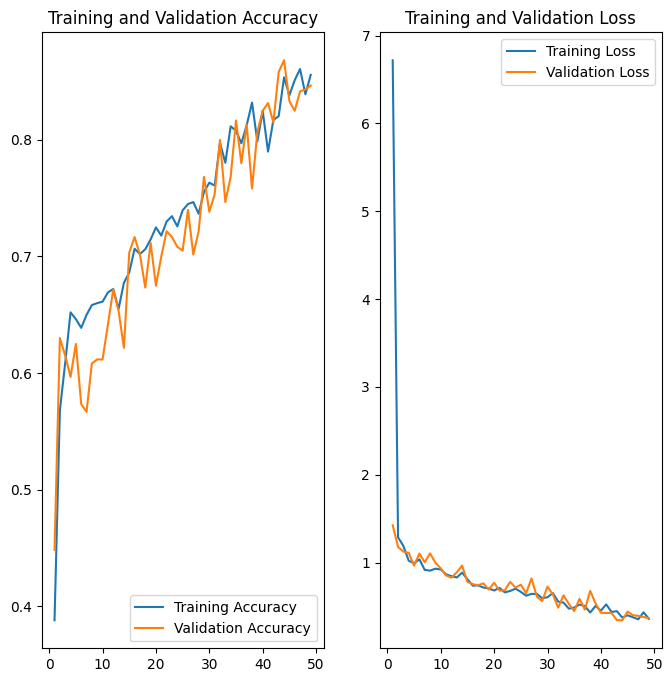

In [191]:
plot(history)

you can see that SVM predicts the color with 99% accuracy

In [193]:
result = CompileSVM(numpydata_test,labels_test)

Accuracy on unknown data is 0.992


and these are the test data. train_test_split spilits 25% of data as test data.

In [194]:
result

,original,predicted
0,3,3
1,7,7
2,1,1
3,7,7
4,4,4
...,...,...
745,5,5
746,4,6
747,5,5
748,4,4


In [126]:
(labels_test15,numpydata_test15) = createNoisyImage(3000,100,15)

<ipython-input-117-db029c55d060>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpydata_noisy = np.empty([numberOfImages, sizeOfImage, sizeOfImage, 3], dtype=np.int)


In [171]:
history15 = compileModel(15)

Found 3000 files belonging to 8 classes.
Using 600 files for validation.
Found 3000 files belonging to 8 classes.
Using 2400 files for training.
Epoch 1/100
75/75 [==============================] - 3s 17ms/step - loss: 15.4747 - acc: 0.3900 - val_loss: 1.2319 - val_acc: 0.5183
Epoch 2/100
75/75 [==============================] - 1s 15ms/step - loss: 1.4422 - acc: 0.4863 - val_loss: 1.3536 - val_acc: 0.5417
Epoch 3/100
75/75 [==============================] - 1s 18ms/step - loss: 1.3652 - acc: 0.5175 - val_loss: 1.1992 - val_acc: 0.5367
Epoch 4/100
75/75 [==============================] - 1s 15ms/step - loss: 1.2910 - acc: 0.5208 - val_loss: 1.1814 - val_acc: 0.5967
Epoch 5/100
75/75 [==============================] - 1s 15ms/step - loss: 1.2791 - acc: 0.5512 - val_loss: 1.2738 - val_acc: 0.6083
Epoch 6/100
75/75 [==============================] - 1s 17ms/step - loss: 1.1896 - acc: 0.6046 - val_loss: 1.0362 - val_acc: 0.6667
Epoch 7/100
75/75 [==============================] - 2s 25ms/s

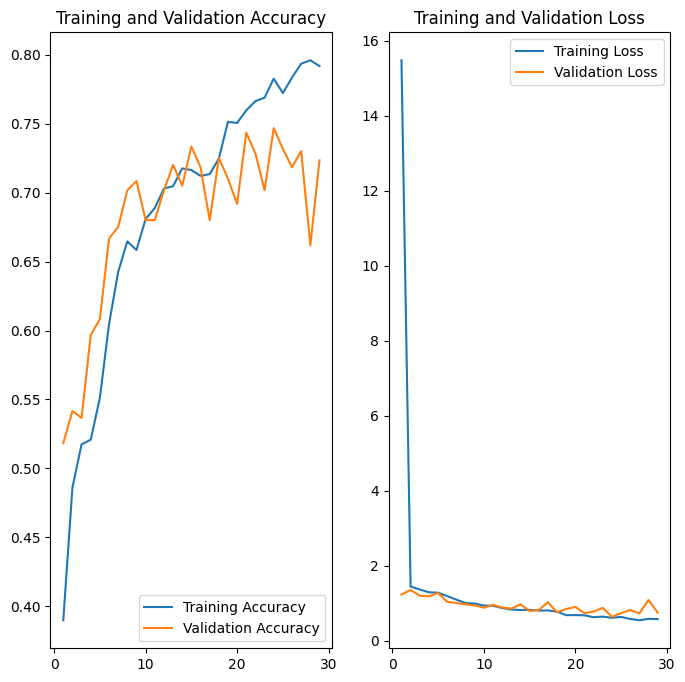

In [172]:
plot(history15)

In [129]:
result15 = CompileSVM(numpydata_test15,labels_test15)

Accuracy on unknown data is 0.8773333333333333


In [130]:
result15

,original,predicted
0,0,0
1,4,4
2,5,5
3,0,0
4,4,6
...,...,...
745,7,7
746,4,4
747,6,6
748,7,7


In [131]:
(labels_test25,numpydata_test25) = createNoisyImage(3000,100,25)

<ipython-input-117-db029c55d060>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpydata_noisy = np.empty([numberOfImages, sizeOfImage, sizeOfImage, 3], dtype=np.int)


In [183]:
history25 = compileModel(25)

Found 3000 files belonging to 8 classes.
Using 600 files for validation.
Found 3000 files belonging to 8 classes.
Using 2400 files for training.
Epoch 1/100
75/75 [==============================] - 3s 17ms/step - loss: 14.4202 - acc: 0.1229 - val_loss: 2.0789 - val_acc: 0.1250
Epoch 2/100
75/75 [==============================] - 1s 15ms/step - loss: 2.0796 - acc: 0.1192 - val_loss: 2.0761 - val_acc: 0.1367
Epoch 3/100
75/75 [==============================] - 1s 17ms/step - loss: 2.0756 - acc: 0.1383 - val_loss: 2.0796 - val_acc: 0.1317
Epoch 4/100
75/75 [==============================] - 1s 17ms/step - loss: 2.0794 - acc: 0.1333 - val_loss: 2.0797 - val_acc: 0.1317
Epoch 5/100
75/75 [==============================] - 1s 15ms/step - loss: 2.0793 - acc: 0.1333 - val_loss: 2.0797 - val_acc: 0.1317
Epoch 6/100
75/75 [==============================] - 1s 15ms/step - loss: 2.0793 - acc: 0.1333 - val_loss: 2.0799 - val_acc: 0.1317
Epoch 7/100
75/75 [==============================] - 1s 17ms/s

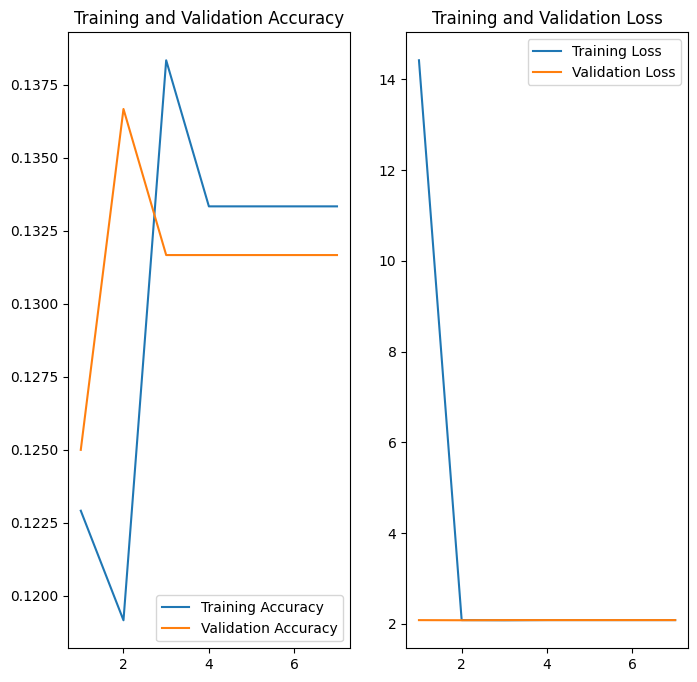

In [184]:
plot(history25)

for images with 25% of noises, CNN was trained not good. but SVM has a good acccuracy in predicting.

In [134]:
result25 = CompileSVM(numpydata_test25,labels_test25)

Accuracy on unknown data is 0.7933333333333333


In [135]:
result25

,original,predicted
0,1,1
1,2,2
2,3,3
3,1,1
4,6,4
...,...,...
745,2,2
746,1,1
747,6,6
748,4,0


In [136]:
(labels_test45,numpydata_test45) = createNoisyImage(3000,100,45)

<ipython-input-117-db029c55d060>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpydata_noisy = np.empty([numberOfImages, sizeOfImage, sizeOfImage, 3], dtype=np.int)


In [185]:
history45 = compileModel(45)

Found 3000 files belonging to 8 classes.
Using 600 files for validation.
Found 3000 files belonging to 8 classes.
Using 2400 files for training.
Epoch 1/100
75/75 [==============================] - 3s 17ms/step - loss: 6.1570 - acc: 0.1963 - val_loss: 1.9052 - val_acc: 0.2867
Epoch 2/100
75/75 [==============================] - 1s 17ms/step - loss: 2.0561 - acc: 0.1571 - val_loss: 1.9583 - val_acc: 0.2100
Epoch 3/100
75/75 [==============================] - 1s 16ms/step - loss: 2.0679 - acc: 0.1425 - val_loss: 2.0792 - val_acc: 0.1217
Epoch 4/100
75/75 [==============================] - 1s 15ms/step - loss: 2.0794 - acc: 0.1304 - val_loss: 2.0792 - val_acc: 0.1350
Epoch 5/100
75/75 [==============================] - 2s 22ms/step - loss: 2.0793 - acc: 0.1258 - val_loss: 2.0781 - val_acc: 0.1350
Epoch 6/100
75/75 [==============================] - 2s 23ms/step - loss: 2.0876 - acc: 0.1479 - val_loss: 2.1559 - val_acc: 0.1500
Epoch 6: early stopping


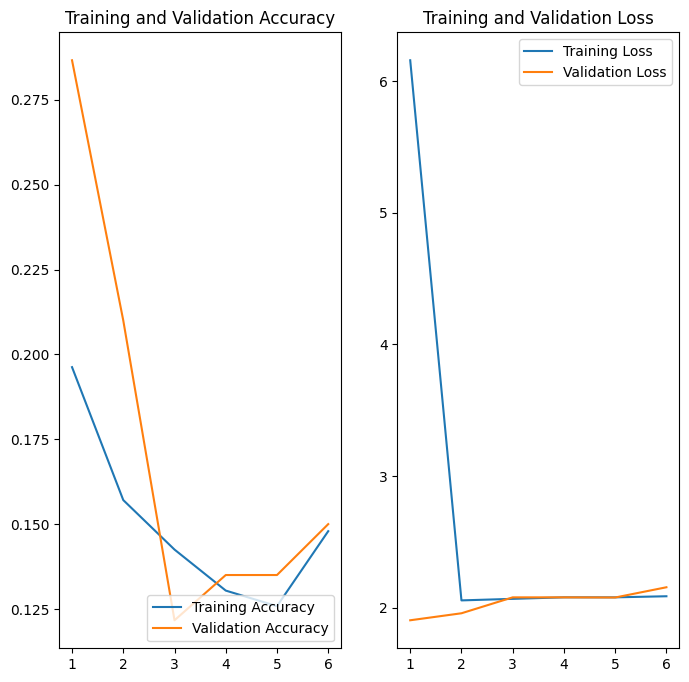

In [186]:
plot(history45)

In [139]:
result45 = CompileSVM(numpydata_test45,labels_test45)

Accuracy on unknown data is 0.592


In [140]:
result45

,original,predicted
0,7,7
1,7,6
2,5,5
3,4,4
4,2,0
...,...,...
745,0,0
746,2,2
747,2,1
748,6,3


you can try SVM with images of 60% noises. it has the accuracy of 45%:)